# CHICAGO TAXI TRIP ANALYSIS

### FINAL PROJECT DATA 603

Installing required packages

In [1]:
!pip install wheel
!pip install pipwin
!pipwin install numpy
!pipwin install shapely
!pipwin install gdal
!pipwin install fiona
!pipwin install pyproj
!pipwin install six
!pipwin install rtree
!pipwin install geopandas
!pip install plotly
!pip install folium

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pipwin/command.py:66: UserWarning: Found a non Windows system. Package installation might not work.
  warn("Found a non Windows system. Package installation might not work.")
Package `numpy` found in cache
https://download.lfd.uci.edu/pythonlibs/w6tyco5e/numpy-1.21.4+vanilla-cp38-cp38-win_amd64.whl
numpy-1.21.4+vanilla-cp38-cp38-win_amd64.whl
File /Users/jaswanthsai/pipwin/numpy-1.21.4+vanilla-cp38-cp38-win_amd64.whl already exists
ERROR: numpy-1.21.4+vanilla-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
Traceback (most recent call last):
  File "/Users/jaswanthsai/opt/anaconda3/bin/pipwin", line 8, in <module>
    sys.exit(main())
  File "/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pipwin/command.py", line 103, in main
    cache.install(package)
  File "/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pipwin/pipwin.py", line 301, in install
    subprocess.check_call([executab

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pipwin/command.py:66: UserWarning: Found a non Windows system. Package installation might not work.
  warn("Found a non Windows system. Package installation might not work.")
Package `pyproj` found in cache
https://download.lfd.uci.edu/pythonlibs/w6tyco5e/pyproj-3.3.0-cp38-cp38-win_amd64.whl
pyproj-3.3.0-cp38-cp38-win_amd64.whl
File /Users/jaswanthsai/pipwin/pyproj-3.3.0-cp38-cp38-win_amd64.whl already exists
ERROR: pyproj-3.3.0-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
Traceback (most recent call last):
  File "/Users/jaswanthsai/opt/anaconda3/bin/pipwin", line 8, in <module>
    sys.exit(main())
  File "/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pipwin/command.py", line 103, in main
    cache.install(package)
  File "/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pipwin/pipwin.py", line 301, in install
    subprocess.check_call([executable, "-m", "pip", "install", whe

Importing required packages for data accessing, analysis and visualization

In [2]:
pip install google

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install google-cloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install google-cloud-vision

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade google-cloud-bigquery

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from pylab import rcParams
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import folium
%matplotlib inline

Importing required packages needed for regression

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from random import randint
from scipy.stats import randint

Cred_Service.json has the access credentials for google cloud. Since the data is present on google clod bigquery we had set an account and project. 
Dataset can be accesses using below link:
https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=chicago_taxi_trips

In [8]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="Cred_Service.json"
client = bigquery.Client(project='angular-argon-307703')

Getting the list of tables in the dataset. Here we have the whole data as one table which is 'taxi_trips'. This is table is our source data.

In [9]:
data_ref = client.dataset("chicago_taxi_trips", project="bigquery-public-data")

# fetch the dataset
dataset = client.get_dataset(data_ref)
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

taxi_trips


# Idenitifying Data issues

The next steps we will check if for each important feature if there are any data issues or issing values. We are considering data from 2014 t0 2020. 2013 data is exempted from analysis based on previous research work on this data and literature review.
2021 data was incomplete and continously changing during the course of this project, so it is removed from the analysis

In [10]:
pip install pyarrow --user

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install --upgrade google-cloud-bigquery[bqstorage,pandas]

zsh:1: no matches found: google-cloud-bigquery[bqstorage,pandas]
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install pandas-gbq==0.14.0

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

Note: you may need to restart the kernel to use updated packages.


### Checking if there are any records with missing trip_start_timestamp

In [14]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Creating a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [16]:
trip_start_time = """ 
            SELECT extract(YEAR from trip_start_timestamp) year,count(*) as trip_start_date_nulls
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE trip_start_timestamp is null
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
            GROUP BY extract(YEAR from trip_start_timestamp)
        """
trip_start_time_job = client.query(trip_start_time)

trip_start_time_result = trip_start_time_job.to_dataframe()

print(trip_start_time_result)

Empty DataFrame
Columns: [year, trip_start_date_nulls]
Index: []


No records are found with missing timestamp

### Checking if there are any records with missing trip_end_timestamp 

In [17]:
trip_end_time = """ 
            SELECT extract(YEAR from trip_start_timestamp) year,count(*) as trip_end_date_nulls,
                   MIN(trip_seconds) min_trip_seconds,max(trip_seconds) as max_trip_seconds
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE trip_end_timestamp is null
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
            GROUP BY extract(YEAR from trip_start_timestamp)
        """

trip_end_time_job = client.query(trip_end_time)

trip_end_time_result1 = trip_end_time_job.to_dataframe()

trip_end_time_result = spark.createDataFrame(trip_end_time_result1)

# Trip_seconds is also missing so we time stamp can not be derived
trip_end_time_result.printSchema()
trip_end_time_result.show()

root
 |-- year: long (nullable = true)
 |-- trip_end_date_nulls: long (nullable = true)
 |-- min_trip_seconds: double (nullable = true)
 |-- max_trip_seconds: double (nullable = true)

+----+-------------------+----------------+----------------+
|year|trip_end_date_nulls|min_trip_seconds|max_trip_seconds|
+----+-------------------+----------------+----------------+
|2017|                662|             NaN|             NaN|
|2015|               3591|             NaN|             NaN|
|2019|                545|             NaN|             NaN|
|2016|               2414|             NaN|             NaN|
|2020|                574|             NaN|             NaN|
|2018|                350|             NaN|             NaN|
|2014|               5869|             NaN|             NaN|
+----+-------------------+----------------+----------------+



### Checking if there are any records where the trip start time is greater than trip end time

In [18]:
trip_time_issues = """ 
            SELECT trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE trip_end_timestamp < trip_start_timestamp
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
        """

trip_time_issues_job = client.query(trip_time_issues)

trip_time_issues_result1 = trip_time_issues_job.to_dataframe()

trip_time_issues_result = spark.createDataFrame(trip_time_issues_result1)

#53155 records have this issue

trip_time_issues_result.describe().show()
# No common data point is identified for this data

+-------+------------+----------+---------------------+----------------------+---------------+----------------+----------------+-----------------+
|summary|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|pickup_latitude|pickup_longitude|dropoff_latitude|dropoff_longitude|
+-------+------------+----------+---------------------+----------------------+---------------+----------------+----------------+-----------------+
|  count|       53177|     53177|                53177|                 53177|          53177|           53177|           53177|            53177|
|   mean|         NaN|       NaN|                  NaN|                   NaN|            NaN|             NaN|             NaN|              NaN|
| stddev|         NaN|       NaN|                  NaN|                   NaN|            NaN|             NaN|             NaN|              NaN|
|    min|         NaN|       0.0|                  1.0|                   1.0|   41.660136051|   -87.913624596|    41.

### Checking for latitude and logitude missing records

In [19]:
latlong = """ 
            SELECT count(*) as pickup_latlong_nulls
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE (pickup_latitude is null or pickup_longitude is null)
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
        """
latlong_job = client.query(latlong)

latlong_result1 = latlong_job.to_dataframe()
latlong_result = spark.createDataFrame(latlong_result1)

latlong_result.printSchema()
latlong_result.show()

root
 |-- pickup_latlong_nulls: long (nullable = true)

+--------------------+
|pickup_latlong_nulls|
+--------------------+
|            18441188|
+--------------------+



### Checking for distribution and existence of other useful features for latitude and logitude missing records

In [20]:
pickup_locations_null = """ 
            SELECT extract(YEAR from trip_start_timestamp) year, min(pickup_community_area) community_area_min, max(pickup_community_area) community_area_max
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            WHERE (pickup_latitude is null or pickup_longitude is null)
            AND extract(YEAR from trip_start_timestamp) between 2014 and 2020
            GROUP BY extract(YEAR from trip_start_timestamp) 
        """

pickup_locations_null_job = client.query(pickup_locations_null)
pickup_locations_null_result1 = pickup_locations_null_job.to_dataframe()
pickup_locations_null_result = spark.createDataFrame(pickup_locations_null_result1)

# community area information is also missing for these records and the records are spanning across all years.
pickup_locations_null_result.describe().show()

+-------+------------------+------------------+------------------+
|summary|              year|community_area_min|community_area_max|
+-------+------------------+------------------+------------------+
|  count|                 7|                 7|                 7|
|   mean|            2017.0|               NaN|               NaN|
| stddev|2.1602468994692976|               NaN|               NaN|
|    min|              2014|               NaN|               NaN|
|    max|              2020|               NaN|               NaN|
+-------+------------------+------------------+------------------+



### Checking for trips that lasted more than 3 hours

In [21]:
time_diff = """ SELECT trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                          WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 AND 2020
                            AND pickup_latitude is not null and dropoff_longitude is not null
                            AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) > 180 """

time_diff_job = client.query(time_diff)

time_diff_result1 = time_diff_job.to_dataframe()
time_diff_result = spark.createDataFrame(time_diff_result1)
# 75% of the data has trips miles less than 9 which should not take morethan 30 minutes 
# and 1567 miles trips is not possible with in chicago
time_diff_result.describe().show()

+-------+------------+----------+---------------------+----------------------+-------------------+-------------------+-------------------+-------------------+
|summary|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area|    pickup_latitude|   pickup_longitude|   dropoff_latitude|  dropoff_longitude|
+-------+------------+----------+---------------------+----------------------+-------------------+-------------------+-------------------+-------------------+
|  count|       68616|     68616|                68616|                 68616|              68616|              68616|              68616|              68616|
|   mean|         NaN|       NaN|                  NaN|                   NaN|  41.90816081692876| -87.67853583621653|  41.91175711026197|  -87.6803300910291|
| stddev|         NaN|       NaN|                  NaN|                   NaN|0.05445070308235079|0.08522378809514006|0.05833210504270917|0.08524705245700195|
|    min|     10833.0|       0.0|             

75% of the data has trips miles less than 9 which should not take morethan 30 minutes and 1567 miles trips is not possible with in chicago

### Checking for trips that have trips total amount less than 3.25 (which is official minimum fare for any trip)

In [22]:
trip_total = """ SELECT count(*)
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                          WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 AND 2020
                            AND pickup_latitude is not null and dropoff_longitude is not null
                            AND trip_total < 3.25 """

trip_total_job = client.query(trip_total)
trip_total_result1 = trip_total_job.to_dataframe()
trip_total_result = spark.createDataFrame(trip_total_result1)
trip_total_result.show()

+------+
|   f0_|
+------+
|185936|
+------+



There are 185936 records with fare less than 3.25

### Checking distribution of trip miles, most of the records have less than 100 mile. Longest route which is from OHare to Hegewisch is only 50 miles considering double the 50 it should be more than 100 for trips with in chicago



In [23]:
trip_miles = """ SELECT round(trip_miles) trip_miles,count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                          WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 AND 2020
                            AND pickup_latitude is not null and dropoff_longitude is not null
                GROUP BY trip_miles """

trip_miles_job = client.query(trip_miles)
trip_miles_result1 = trip_miles_job.to_dataframe()
trip_miles_result = spark.createDataFrame(trip_miles_result1)
trip_miles_result.show()

+----------+----------+
|trip_miles|trip_count|
+----------+----------+
|      21.0|    258922|
|      27.0|     38800|
|      84.0|       415|
|      98.0|       248|
|     136.0|       273|
|     178.0|       645|
|     163.0|       126|
|     167.0|       151|
|     157.0|       102|
|     174.0|       358|
|     261.0|        19|
|     276.0|        11|
|     525.0|         9|
|     424.0|         4|
|     460.0|        86|
|    1330.0|        33|
|     530.0|        76|
|     670.0|        40|
|    1410.0|        26|
|    1630.0|        36|
+----------+----------+
only showing top 20 rows



### Preparing the filter which will be used for all the queries in this notebook. 
We are going to fiter all the records which we identified as issues in the above section.
The conditions are as followed
1. Year of Pickup time should be between 2014 and 2020
2. Pickup latitude and logitudes should not be NULL
3. Trip end time stamp should not be NULL
4. Trip start time should be less than trip end time
5. Trip duration should be less than or equal to 180 minutes (3 hours)
6. Pickup and dropoff community areas should be present
7. Trip total amount should atleast be $3.25
8. Trip miles should be less than or equal to 100 miles

In [24]:
filters = """ 
            WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 and 2020
            AND pickup_latitude is not null and pickup_longitude is not null
            AND trip_end_timestamp is not null
            AND trip_end_timestamp >= trip_start_timestamp
            AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) < 180
            AND pickup_community_area is not null AND pickup_community_area > 0
            AND dropoff_community_area is not null AND dropoff_community_area > 0
            AND trip_total >= 3.25
            AND trip_miles <= 100
        """

### Query to get the number of rides per day, we will see how the trend look like over the years

In [25]:
date_and_trips = """ 
            SELECT DATE(trip_start_timestamp) trip_date,
                   count(*) as trip_count
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            """ + filters + """
            GROUP BY DATE(trip_start_timestamp)
        """

date_and_trips_job = client.query(date_and_trips)
date_and_trips_result1 = date_and_trips_job.to_dataframe()
date_and_trips_result = spark.createDataFrame(date_and_trips_result1)
date_and_trips_result.printSchema()
date_and_trips_result.show()

root
 |-- trip_date: date (nullable = true)
 |-- trip_count: long (nullable = true)

+----------+----------+
| trip_date|trip_count|
+----------+----------+
|2015-03-16|     65220|
|2015-01-21|     67302|
|2015-01-14|     76053|
|2014-06-14|    120031|
|2014-09-01|     64135|
|2014-12-25|     18213|
|2014-12-23|     63031|
|2014-12-30|     67076|
|2014-06-26|    103832|
|2016-08-19|     81685|
|2016-02-20|     79358|
|2016-12-15|     91644|
|2016-06-09|     82734|
|2015-06-13|    102948|
|2020-01-21|     36154|
|2014-02-25|     68956|
|2014-03-01|     96325|
|2015-06-29|     63587|
|2015-09-24|     70213|
|2015-06-25|     84564|
+----------+----------+
only showing top 20 rows



In [26]:
date_and_trips_result_pd_1 = date_and_trips_result.toPandas()

In [27]:
# Changing the trip_date column to datetime and setting the trip_date as index
date_and_trips_result_pd_1['trip_date']= pd.to_datetime(date_and_trips_result_pd_1['trip_date'])
date_and_trips_result_pd = date_and_trips_result_pd_1.set_index('trip_date')

## Data Visualization

### Visualization to show trips per day over the year

<AxesSubplot:xlabel='trip_date'>

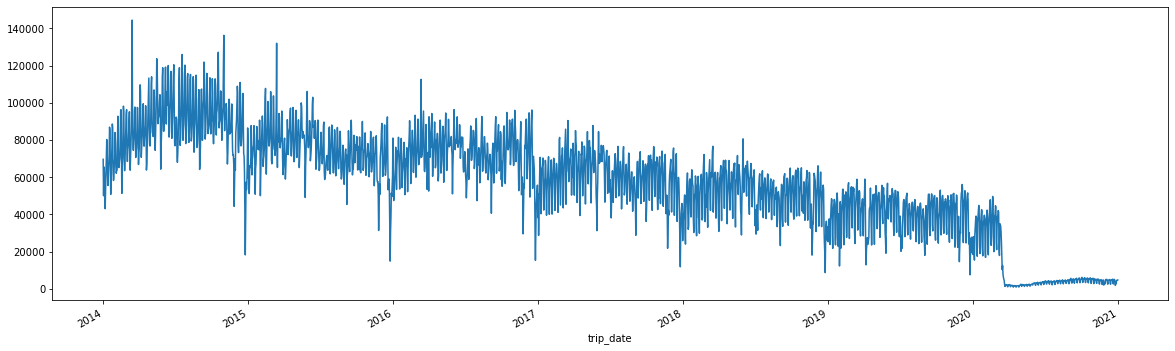

In [28]:
# The figure shows the trips per day over the years
fig, ax = plt.subplots(nrows=1, ncols=1)
date_and_trips_result_pd.plot(figsize=(20, 6),ax=ax,legend=False)

Statistical Analysis, to understanding trend, sesonal behaviour

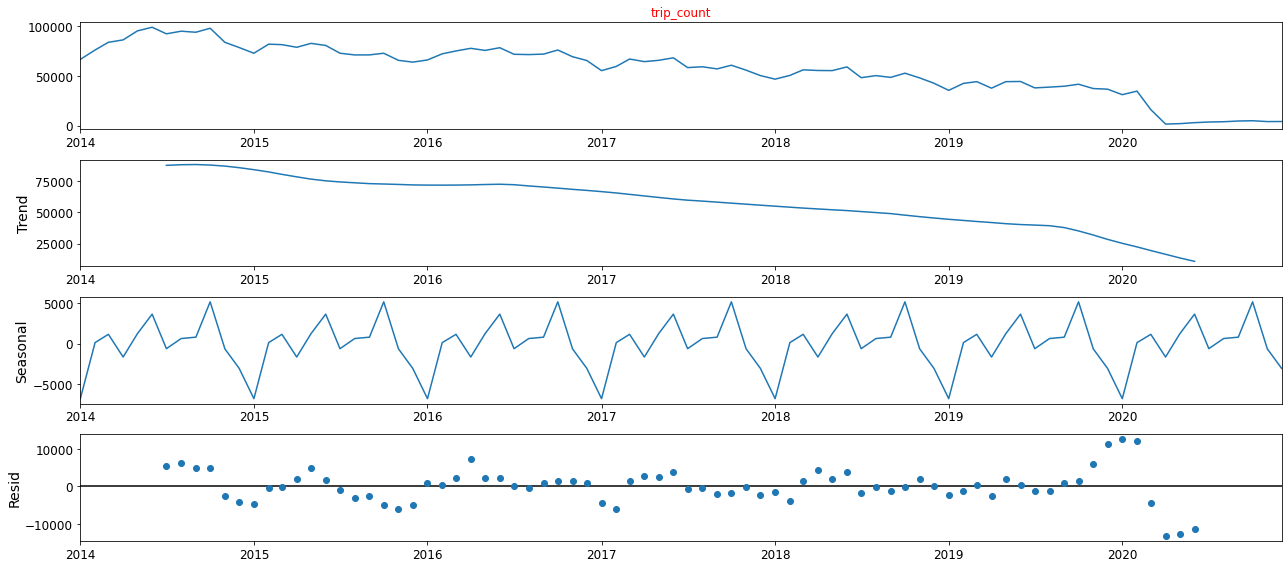

In [29]:
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'r'

y = date_and_trips_result_pd['trip_count'].resample('MS').mean()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Number of rides per month for each year

In [30]:
monthly_rides_query = """ SELECT * FROM ( SELECT EXTRACT(MONTH from trip_start_timestamp) index_month,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 EXTRACT(YEAR FROM trip_start_timestamp) year,
                                 count(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(MONTH from trip_start_timestamp),EXTRACT(YEAR FROM trip_start_timestamp),
                             FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp))) as a
                        ORDER BY index_month """

monthly_rides_query_job = client.query(monthly_rides_query)

monthly_rides_query_result = monthly_rides_query_job.to_dataframe()

monthly_rides_query_result.head()

index_month    month  year    trips
0            1  January  2017  1714197
1            1  January  2020   965584
2            1  January  2019  1099897
3            1  January  2014  2065180
4            1  January  2016  2047411

### Plotting the number of rides per month for each year.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


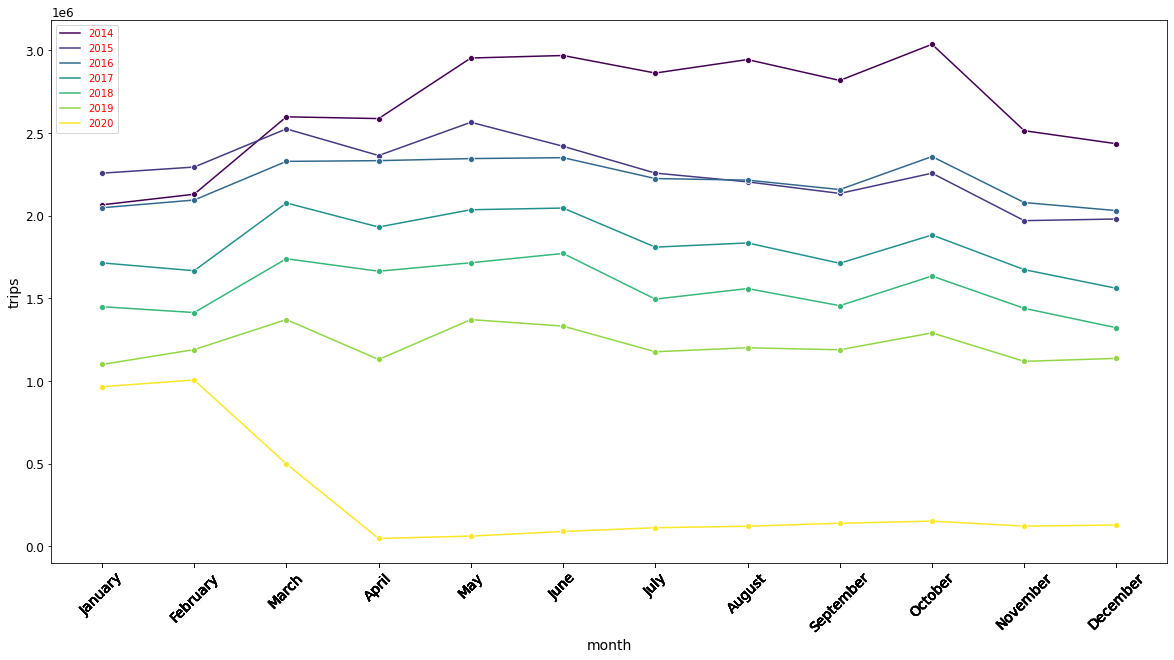

In [31]:
plt.figure(figsize=(20,10))

lp = sns.lineplot('month', 'trips', ci=None, marker='o', palette = "viridis",
             hue='year', data=monthly_rides_query_result)
lp.legend(loc='upper left')

plt.xticks(monthly_rides_query_result['month'], rotation=45,size=14)
plt.show()

#### There is drastic decline in trips from February to April of 2020 when compared to all other years.  
#### October has high number of trips in most years

## Percentage Change

Below query is to get the percentage of trips increased or decresed compared to previous month for year 2020.
1. Jan2020 percentage is the percentage change in number of trips compared to Dec2019
2. Feb2020 percentage is the percentage change in number of trips compared to Jan2020 and so on.

In [32]:
month_to_month = """ SELECT ((Jan2020-Dec2019)/Dec2019)*100 as Jan2020,
                            ((Feb2020-Jan2020)/Jan2020)*100 as Feb2020,
                            ((Mar2020-Feb2020)/Feb2020)*100 as Mar2020,
                            ((Apr2020-Mar2020)/Mar2020)*100 as Apr2020,
                            ((May2020-Apr2020)/Apr2020)*100 as May2020,
                            ((Jun2020-May2020)/May2020)*100 as Jun2020,
                            ((Jul2020-Jun2020)/Jun2020)*100 as Jul2020,
                            ((Aug2020-Jul2020)/Jul2020)*100 as Aug2020,
                            ((Sep2020-Aug2020)/Aug2020)*100 as Sep2020,
                            ((Oct2020-Sep2020)/Sep2020)*100 as Oct2020,
                            ((Nov2020-Oct2020)/Oct2020)*100 as Nov2020,
                            ((Dec2020-Nov2020)/Nov2020)*100 as Dec2020,
                    FROM (SELECT 
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=1 then 1 else 0 END) Jan2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=2 then 1 else 0 END) Feb2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=3 then 1 else 0 END) Mar2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=4 then 1 else 0 END) Apr2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=5 then 1 else 0 END) May2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=6 then 1 else 0 END) Jun2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=7 then 1 else 0 END) Jul2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=8 then 1 else 0 END) Aug2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=9 then 1 else 0 END) Sep2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=10 then 1 else 0 END) Oct2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=11 then 1 else 0 END) Nov2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=12 AND EXTRACT(Year from trip_start_timestamp)=2020 then 1 else 0 END) Dec2020,
                                 SUM(CASE WHEN EXTRACT(MONTH from trip_start_timestamp)=12 AND EXTRACT(Year from trip_start_timestamp)=2019 then 1 else 0 END) Dec2019
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                            AND (EXTRACT(YEAR from trip_start_timestamp)=2020 OR (EXTRACT(YEAR from trip_start_timestamp)=2019 AND EXTRACT(MONTH from trip_start_timestamp)=12) )
                        ) as a"""

month_to_month_job = client.query(month_to_month)

month_to_month_result = month_to_month_job.to_dataframe()

month_to_month_result.head()

Jan2020   Feb2020    Mar2020    Apr2020    May2020  Jun2020    Jul2020  \
0 -15.064512  4.213823 -50.422053 -90.370002  30.131341  44.4089  25.207403   

    Aug2020   Sep2020   Oct2020    Nov2020   Dec2020  
0  7.994444  14.71682  9.236383 -19.689631  5.165313

### Bar plot with percentage changes

In [33]:
line = pd.Series(month_to_month_result.iloc[0,0:])
px.bar(line,x=line.index.values.tolist(),y=line,text=line,template='presentation',hover_name=line.index.values.tolist())

### Query to get the average number of rides in a day per hour during weekdays and weekends for each year DAYOFWEEK -1 is Sunday , 7 is Saturday

In [34]:
hourly_rides_query = """ SELECT ride_hour,weekday,ride_year,AVG(number_of_rides) as number_of_rides
                           FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(HOUR from trip_start_timestamp) ride_hour,
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END AS weekday,
                                 EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                 COUNT(*) number_of_rides
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(HOUR from trip_start_timestamp),
                                 EXTRACT(DATE from trip_start_timestamp),
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END,
                                 EXTRACT(YEAR from trip_start_timestamp) ) as a
                        GROUP BY ride_hour,weekday,ride_year
                        ORDER BY ride_hour """

hourly_rides_query_job = client.query(hourly_rides_query)

hourly_rides_query_result = hourly_rides_query_job.to_dataframe()

hourly_rides_query_result.head()

ride_hour   weekday  ride_year  number_of_rides
0          0  Weekdays       2014      2305.429119
1          0  Weekdays       2015      1880.022989
2          0  Weekdays       2016      1617.264368
3          0  Weekends       2015      5160.009615
4          0  Weekends       2020       282.163462

### Plotting the average trips per hours for both weekdays and weekends

Text(0.5, 0.98, 'Hourly Averages')

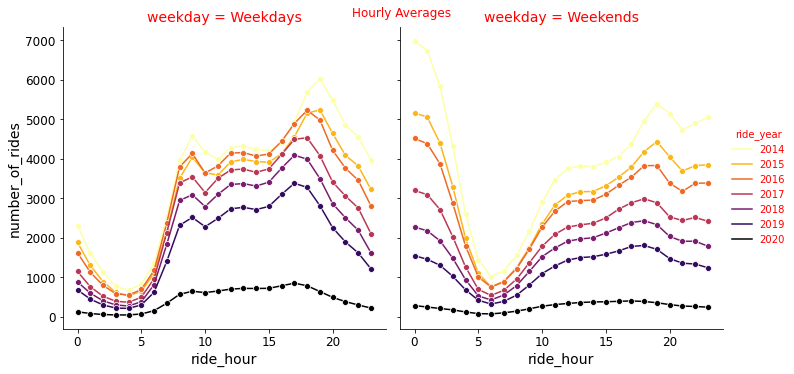

In [35]:
f = sns.relplot(x='ride_hour',y='number_of_rides',hue='ride_year',marker='o', palette = "inferno_r",col='weekday',kind='line',
            data=hourly_rides_query_result)
f.fig.suptitle("Hourly Averages")

### Query to get the avarage number of rides for each day of the week and year

In [36]:
weekday_rides_query = """ SELECT weekday,ride_week,ride_year,AVG(number_of_rides) as number_of_rides 
                            FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS weekday,
                                 FORMAT_DATE('%A', trip_start_timestamp) ride_week,
                                 EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                 COUNT(*) number_of_rides
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                                 EXTRACT(DAYOFWEEK FROM trip_start_timestamp),
                                 FORMAT_DATE('%A', trip_start_timestamp),
                                 EXTRACT(YEAR from trip_start_timestamp) ) as a
                        GROUP BY weekday,ride_week,ride_year
                        ORDER BY weekday """

weekday_rides_query_job = client.query(weekday_rides_query)

weekday_rides_query_result = weekday_rides_query_job.to_dataframe()

weekday_rides_query_result.head()

weekday ride_week  ride_year  number_of_rides
0        1    Sunday       2018     36661.134615
1        1    Sunday       2014     83792.019231
2        1    Sunday       2019     26626.230769
3        1    Sunday       2015     67149.538462
4        1    Sunday       2017     45828.415094

### Bar plot to show the number of rides per week
2020 has lowest number of ride for all the 7 days.

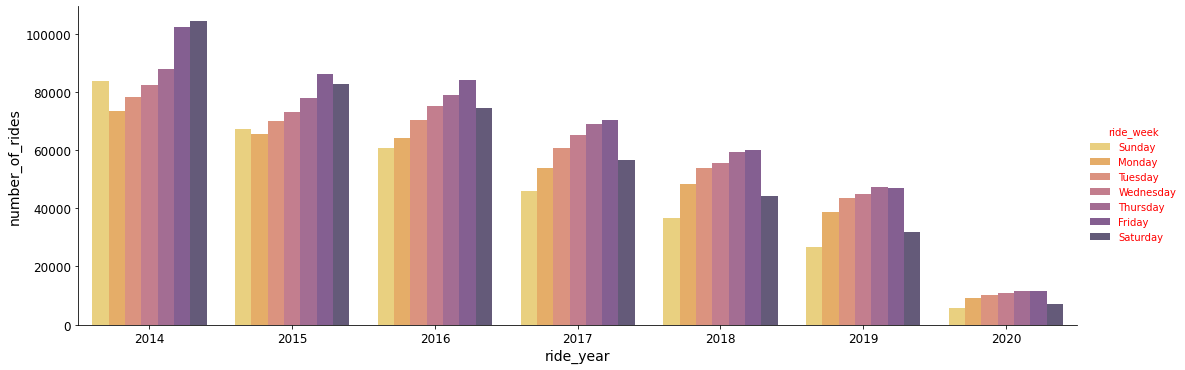

In [37]:
sns.catplot(x='ride_year',y='number_of_rides',hue='ride_week',
            data=weekday_rides_query_result,kind='bar',aspect=30/10,palette='inferno_r',alpha=0.7)

### Below query is to get the percentage losses based on total amount for each company for the years 2019, 2020

In [38]:
company_rides_query = """ SELECT company,rides2019,rides2020,((rides2020-rides2019)/rides2019)*100 as loss_percent FROM (SELECT 
                                 company,
                                 SUM(CASE WHEN EXTRACT(YEAR from trip_start_timestamp)=2019 then trip_total else 0 END) rides2019,
                                 SUM(CASE WHEN EXTRACT(YEAR from trip_start_timestamp)=2020 then trip_total else 0 END) rides2020,
                                 SUM(trip_total) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                            AND EXTRACT(YEAR from trip_start_timestamp) in (2019,2020)
                            AND REGEXP_CONTAINS(company, r'^[[:alpha:]]')
                        GROUP BY company) as a
                        WHERE rides2019 > 0
                        ORDER BY company """

company_rides_query_job = client.query(company_rides_query)

company_rides_query_result = company_rides_query_job.to_dataframe()

company_rides_query_result

company    rides2019    rides2020  \
0                        American United     18656.47         0.00   
1       American United Taxi Affiliation     37625.23         0.00   
2                           Blue Diamond    960148.57     12270.33   
3      Blue Ribbon Taxi Association Inc.  10266022.78   1900944.71   
4                           Checker Taxi     13549.04         0.00   
5               Checker Taxi Affiliation   1269907.86      7074.46   
6              Chicago Carriage Cab Corp  28324129.74   4033832.95   
7                   Chicago Independents   3254385.90    934344.88   
8           Chicago Medallion Management   1641066.45    109964.40   
9                   Chicago Star Taxicab      3783.16         0.00   
10                       Chicago Taxicab   2175136.46   1402079.70   
11               Choice Taxi Association   7557289.55   1089742.58   
12                          City Service  16719594.66   3798526.14   
13                             Flash Cab  32401083.58  11929728.67   
14                            Globe Taxi   2702405.17    149803.08   
15                       Gold Coast Taxi    195488.03         0.00   
16                 KOAM Taxi Association   1933423.37    262671.06   
17                        Leonard Cab Co    218793.35     32148.31   
18                      Medallion Leasin  21651807.24   3669926.74   
19                      Metro Jet Taxi A   2130419.82   2071463.78   
20             Nova Taxi Affiliation Llc   3976105.18    368280.49   
21  Patriot Taxi Dba Peace Taxi Associat   3111430.74    545693.41   
22                       Petani Cab Corp    109989.51     42162.39   
23                            Setare Inc    420808.83    162828.98   
24             Star North Management LLC  12649518.58   2314501.45   
25                              Sun Taxi  20581991.19   3929276.48   
26       Taxi Affiliation Service Yellow   5594394.24     40759.83   
27             Taxi Affiliation Services  52378735.32  15437538.38   
28         Taxicab Insurance Agency, LLC   5019628.71   1918415.64   
29                   Top Cab Affiliation   3436244.82    955874.99   
30                             U Taxicab     93537.46    301939.26   
31                            Yellow Cab     23837.67         0.00   

    loss_percent  
0    -100.000000  
1    -100.000000  
2     -98.722038  
3     -81.483143  
4    -100.000000  
5     -99.442915  
6     -85.758316  
7     -71.289672  
8     -93.299211  
9    -100.000000  
10    -35.540610  
11    -85.580246  
12    -77.280991  
13    -63.181081  
14    -94.456676  
15   -100.000000  
16    -86.414199  
17    -85.306542  
18    -83.050252  
19     -2.767344  
20    -90.737657  
21    -82.461657  
22    -61.666899  
23    -61.305712  
24    -81.702850  
25    -80.909153  
26    -99.271417  
27    -70.527088  
28    -61.781722  
29    -72.182570  
30    222.800363  
31   -100.000000

### Bar plot showing the percentage gain or loss for each company

In [39]:
fig = px.bar(company_rides_query_result,y='loss_percent',x='company')
fig.show()

### Query to get the avarage tip amount for each day and plotting

<AxesSubplot:xlabel='trip_date'>

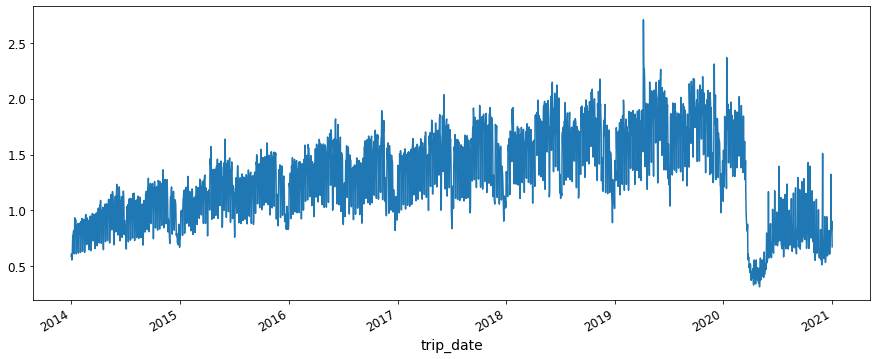

In [40]:
tips_behaviour = """ 
            SELECT DATE(trip_start_timestamp) trip_date,
                   avg(tips) as tip_amount
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
            """ + filters + """
            GROUP BY DATE(trip_start_timestamp)
        """

tips_behaviour_job = client.query(tips_behaviour)

tips_behaviour_result = tips_behaviour_job.to_dataframe()

# Changing trip_date from string to datetime 
tips_behaviour_result['trip_date']= pd.to_datetime(tips_behaviour_result['trip_date'])

# Setting trip_date as index for plotting
tips_behaviour_result = tips_behaviour_result.set_index('trip_date')

fig, ax = plt.subplots(nrows=1, ncols=1)

tips_behaviour_result.plot(figsize=(15, 6),ax=ax,legend=False)


### Below query gets the number of unique active taxis that have atleast one trip for each month of 2020

In [41]:
active_taxis = """ SELECT index_month,month,active_taxis
                     FROM (SELECT EXTRACT(MONTH from trip_start_timestamp) index_month,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 COUNT(DISTINCT taxi_id) active_taxis
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                           AND EXTRACT(YEAR from trip_start_timestamp) = 2020
                        GROUP BY EXTRACT(MONTH from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp))) a
                        ORDER BY index_month """

active_taxis_job = client.query(active_taxis)

active_taxis_result = active_taxis_job.to_dataframe()

active_taxis_result.head()

index_month     month  active_taxis
0            1   January          3813
1            2  February          3866
2            3     March          3829
3            4     April           635
4            5       May           450

### Plotting the number of active taxis for each month of 2020

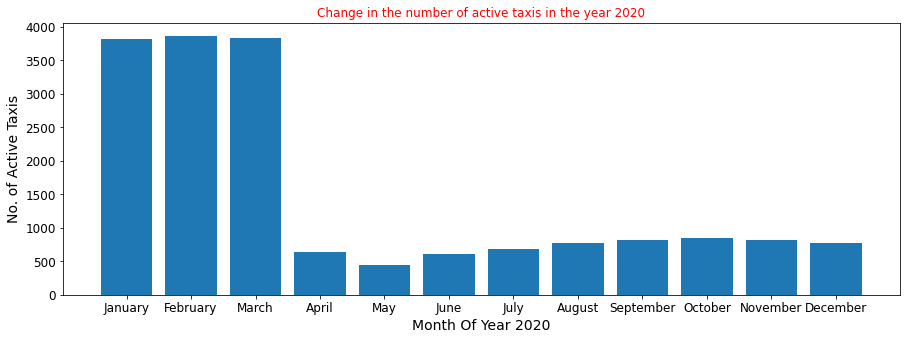

In [42]:
fig = plt.figure(figsize = (15, 5))

plt.bar(active_taxis_result['month'],active_taxis_result['active_taxis'])

plt.xlabel("Month Of Year 2020")
plt.ylabel("No. of Active Taxis")
plt.title("Change in the number of active taxis in the year 2020")
plt.show()

### The below query has two parts
1. First part of the query get the avearge travel times (In minutes) over the years for each day
2. Second part of the query get the avearge travel distances (miles) over the years for each day

In [43]:
avg_travel_times = """ SELECT month_index,date,year,month,weekday,measurement_type,measurement_value
                     FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 EXTRACT(MONTH from trip_start_timestamp) month_index,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END AS weekday,
                                 'Trip Time' as measurement_type,
                                 AVG(trip_seconds/60) measurement_value
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                                EXTRACT(YEAR from trip_start_timestamp),
                                EXTRACT(MONTH from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END
                            UNION ALL
                            SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 EXTRACT(MONTH from trip_start_timestamp) month_index,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END AS weekday,
                                 'Trip Distance' as measurement_type,
                                 AVG(trip_miles) measurement_value
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                                EXTRACT(YEAR from trip_start_timestamp),
                                EXTRACT(MONTH from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                 CASE WHEN EXTRACT(DAYOFWEEK FROM trip_start_timestamp) IN (1,7) THEN 'Weekends' else 'Weekdays' END) a
                        ORDER BY month_index """

avg_travel_times_job = client.query(avg_travel_times)
avg_travel_times_result = avg_travel_times_job.to_dataframe()
# taking the mean for each year, month, weekday and measurememt type (types are travel time and travel distance)
travel_times = avg_travel_times_result.groupby(['month_index','year','month','weekday','measurement_type'], as_index=False)['measurement_value'].mean()
travel_times.columns=['MONTH_INDEX','YEAR','MONTH','WEEKDAY','MEASUREMENT_TYPE','MEASUREMENT_VALUE']
# Seperating the results for travel times and travel distances
trip_distance =  travel_times.loc[travel_times['MEASUREMENT_TYPE'] == 'Trip Distance']
trip_travel_times =  travel_times.loc[travel_times['MEASUREMENT_TYPE'] == 'Trip Time']
trip_distance.head()

MONTH_INDEX  YEAR    MONTH   WEEKDAY MEASUREMENT_TYPE  MEASUREMENT_VALUE
0            1  2014  January  Weekdays    Trip Distance           2.061655
2            1  2014  January  Weekends    Trip Distance           1.990869
4            1  2015  January  Weekdays    Trip Distance           2.772031
6            1  2015  January  Weekends    Trip Distance           2.690116
8            1  2016  January  Weekdays    Trip Distance           2.885560

### Plotting both travel time and distances

Text(0.5, 0.98, 'Travel Times')

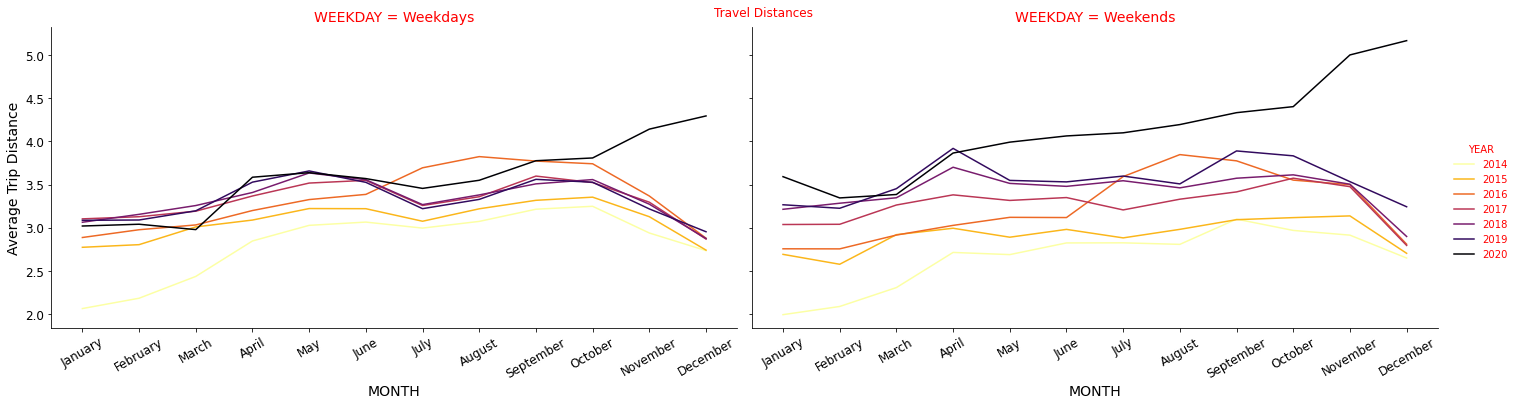

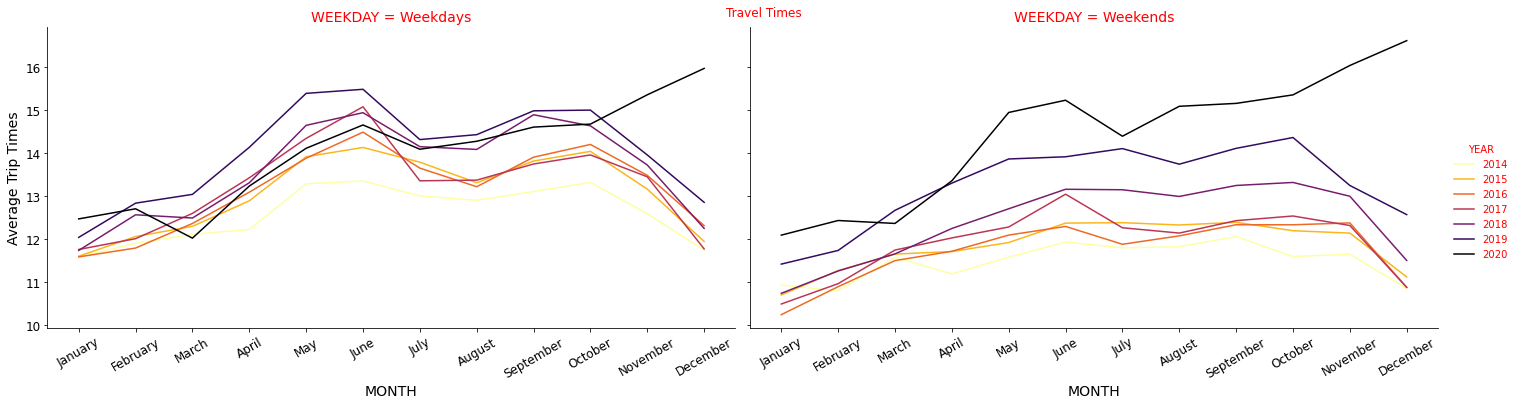

In [44]:
td = sns.relplot(x='MONTH',y='MEASUREMENT_VALUE',hue='YEAR',col='WEEKDAY',palette = "inferno_r",kind='line',
            data=trip_distance,aspect=10/5)

td.set_xticklabels(rotation=30)
td.set_ylabels('Average Trip Distance')
td.fig.suptitle("Travel Distances")

tt = sns.relplot(x='MONTH',y='MEASUREMENT_VALUE',hue='YEAR',col='WEEKDAY',palette = "inferno_r",kind='line',
            data=trip_travel_times,aspect=10/5)

tt.set_xticklabels(rotation=30)
tt.set_ylabels('Average Trip Times')
tt.fig.suptitle("Travel Times")

### Query to get the average wait time of the taxis over the years starting from 2018.
Wait time is time in between dropoff and next pickup

In [45]:
wait_times = """ SELECT * FROM 
                          (SELECT extract(date from date) trip_date,avg(wait_time) wait_time 
                             FROM (
                                   SELECT taxi_id,date,date_l,TIMESTAMP_DIFF(date, date_l, MINUTE) wait_time
                                    FROM 
                                        (SELECT taxi_id,trip_start_timestamp date,
                                                lag(trip_start_timestamp) 
                                                OVER (PARTITION BY taxi_id ORDER BY trip_start_timestamp) date_l
                                           FROM bigquery-public-data.chicago_taxi_trips.taxi_trips
                                           """ + filters + """
                                            AND  EXTRACT(year from trip_start_timestamp)>2018))
                                    GROUP BY extract(date from date))
                        WHERE wait_time<=1440
                    ORDER BY wait_time """

wait_times_job = client.query(wait_times)
wait_times_result = wait_times_job.to_dataframe()
# changing trip_date to datetime and setting it as index for plotting
wait_times_result['trip_date']= pd.to_datetime(wait_times_result['trip_date'])
wait_times_result = wait_times_result.set_index('trip_date')
wait_times_result.head()

wait_time
trip_date             
2019-01-01   69.486318
2019-03-16  104.784631
2019-12-06  107.698275
2019-05-17  109.563845
2019-12-12  111.106504

### Plotting average wait time

<AxesSubplot:xlabel='trip_date'>

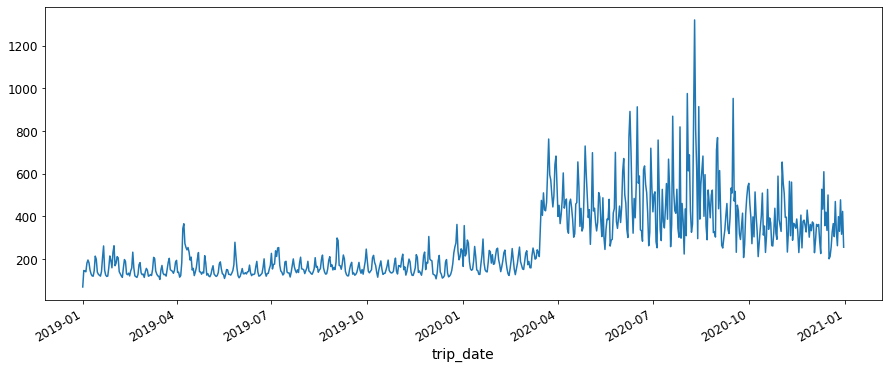

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1)
wait_times_result.plot(figsize=(15, 6),ax=ax,legend=False)

### Query to get the average trips per taxi in a day over the years starting from 2018

In [47]:
trips_per_taxi = """ SELECT trip_date,AVG(trips) as trips
                       FROM 
                           (SELECT taxi_id,EXTRACT(DATE FROM trip_start_timestamp) trip_date,count(*) trips
                              FROM bigquery-public-data.chicago_taxi_trips.taxi_trips
                              """ + filters + """
                               AND  EXTRACT(year from trip_start_timestamp)>2018
                          GROUP BY taxi_id,EXTRACT(DATE FROM trip_start_timestamp))
                    GROUP BY trip_date """

trips_per_taxi_job = client.query(trips_per_taxi)

trips_per_taxi_result = trips_per_taxi_job.to_dataframe()

# changing trip_date to datetime and setting it as index for plotting
trips_per_taxi_result['trip_date']= pd.to_datetime(trips_per_taxi_result['trip_date'])
trips_per_taxi_result = trips_per_taxi_result.set_index('trip_date')
trips_per_taxi_result["trips"] = trips_per_taxi_result["trips"].astype(float).astype(int)
trips_per_taxi_result.head()

trips
trip_date        
2020-02-08      8
2020-02-22      9
2020-02-07     11
2020-02-18     11
2020-02-11     11

### Plotting average trips per taxi in a day

<AxesSubplot:xlabel='trip_date'>

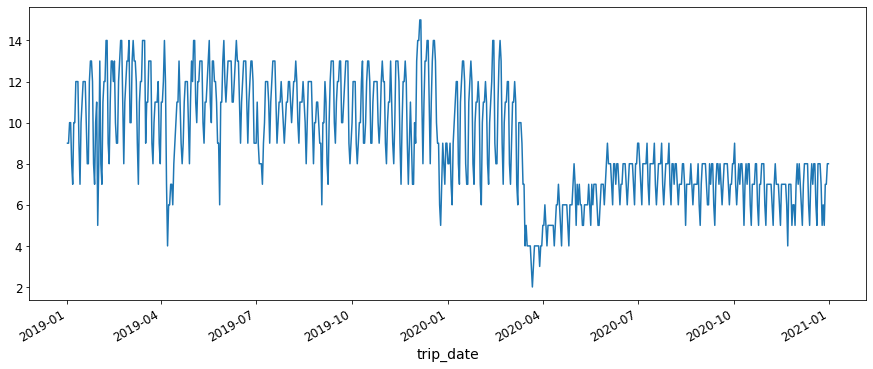

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1)

trips_per_taxi_result.plot(figsize=(15, 6),ax=ax,legend=False)

Reading shape file for the plotting using GeoPandas
The shape file is downloaded from below website
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

In [49]:
# chicago_map = gpd.read_file("Project/geo_export_548d824e-98de-4d9c-9ba4-50a151c3f993.shp")
chicago_map = gpd.read_file("Boundaries - Community Areas (current)/geo_export_b5564fc0-d914-4263-816a-3ad3cdd425bb.shp")

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



1. pickup_area_query - This query gets the number of trips for each day and each pickup community area for the years from 2014 to 2020
2. dropoff_area_query - This query gets the number of trips for each day and each dropoff community area for the years from 2014 to 2020


#### period column is calcaulated as below:
1. If the trip happend before March- 2020 then it is considered PRE-COVID
2. If the trip happend after March- 2020 then it is considered COVID  

In [50]:
pickup_area_query = """ SELECT * FROM (SELECT 
                                 pickup_community_area as area_num_1,
                                 DATE(trip_start_timestamp) trip_date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND pickup_community_area > 0
                        GROUP BY pickup_community_area,
                        DATE(trip_start_timestamp),
                                 EXTRACT(YEAR from trip_start_timestamp),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        ORDER BY area_num_1 """

pickup_area_query_job = client.query(pickup_area_query)

pickup_area_query_result = pickup_area_query_job.to_dataframe()

# Changing the data types of area_num_1 column in both pickup_area_query_result and chicago_map so that we can join them together
pickup_area_query_result['area_num_1'] = pickup_area_query_result['area_num_1'].astype(int)
chicago_map['area_num_1'] = chicago_map['area_num_1'].astype(int)

# Taking the mean for the number of trips basing pickup area and period
pickup_area_query_result = pickup_area_query_result.groupby(['area_num_1','period'], as_index=False)['trips'].mean()
pickup_area_query_result.columns=['area_num_1','period','trips']
pickup_area_query_result.head()

# Joining pickup_area and chicago_map based on area_num_1 (pickup community area)
pickup_area_density_result = chicago_map.merge(pickup_area_query_result, on="area_num_1", how = 'inner')

# Repeating above steps for dropoff community area
dropoff_area_query = """ SELECT * FROM (SELECT 
                                 dropoff_community_area as area_num_1,
                                 DATE(trip_start_timestamp) trip_date,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND dropoff_community_area > 0
                        GROUP BY dropoff_community_area,
                                 DATE(trip_start_timestamp),
                                 EXTRACT(YEAR from trip_start_timestamp),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        ORDER BY area_num_1 """

dropoff_area_query_job = client.query(dropoff_area_query)

dropoff_area_query_result = dropoff_area_query_job.to_dataframe()

# Changing the data types of area_num_1 column dropoff_area_query_result to join with chicago_map
dropoff_area_query_result['area_num_1'] = dropoff_area_query_result['area_num_1'].astype(int)

# Taking the mean for the number of trips basing dropoff area and period
dropoff_area_query_result = dropoff_area_query_result.groupby(['area_num_1','period'], as_index=False)['trips'].mean()
dropoff_area_query_result.columns=['area_num_1','period','trips']
dropoff_area_query_result.head()

# Joining dropoff_area_density_result and chicago_map based on area_num_1 (dropoff community area)
dropoff_area_density_result = chicago_map.merge(dropoff_area_query_result, on="area_num_1", how = 'inner')

dropoff_area_density_result.head()

area  area_num_1 area_numbe  comarea  comarea_id    community  perimeter  \
0   0.0          35         35      0.0         0.0      DOUGLAS        0.0   
1   0.0          35         35      0.0         0.0      DOUGLAS        0.0   
2   0.0          36         36      0.0         0.0      OAKLAND        0.0   
3   0.0          36         36      0.0         0.0      OAKLAND        0.0   
4   0.0          37         37      0.0         0.0  FULLER PARK        0.0   

     shape_area     shape_len  \
0  4.600462e+07  31027.054510   
1  4.600462e+07  31027.054510   
2  1.691396e+07  19565.506153   
3  1.691396e+07  19565.506153   
4  1.991670e+07  25339.089750   

                                            geometry     period       trips  
0  POLYGON ((-87.60914 41.84469, -87.60915 41.844...      COVID   65.225490  
1  POLYGON ((-87.60914 41.84469, -87.60915 41.844...  PRE-COVID  174.121279  
2  POLYGON ((-87.59215 41.81693, -87.59231 41.816...      COVID   21.418301  
3  POLYGON ((-87.59215 41.81693, -87.59231 41.816...  PRE-COVID   21.322523  
4  POLYGON ((-87.62880 41.80189, -87.62879 41.801...      COVID   12.088235

In [51]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [52]:
from shapely.geometry import LineString
from descartes import PolygonPatch

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the con

Text(0.5, 1.0, 'Average Dropoffs Per Day During COVID')

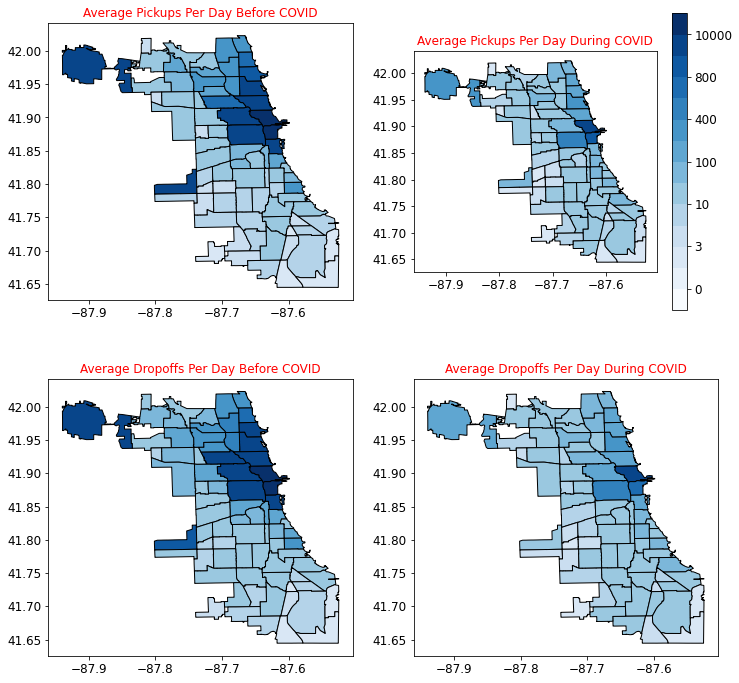

In [53]:
# 4 axis to plot pickup and dropoff densities before and during COVID period
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,12))

# Color map is set to Blues , a sequential color map
cmap = mpl.cm.Blues
# Setting the bounds to be consistent for all 4 axis
bounds = [-1, 0, 1, 3, 5, 10, 50, 100, 200, 400, 600, 800, 1000, 10000, 15000]
# Mapping bounds and colors to be used for legend
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Seperate the pickup data from the result set based on period
pickup_precovid = pickup_area_density_result.loc[pickup_area_density_result['period'] == 'PRE-COVID']
pickup_covid = pickup_area_density_result.loc[pickup_area_density_result['period'] == 'COVID']

# Pickup density for precovid plot
ax1 = pickup_precovid.plot(column="trips",legend=False,
                        edgecolor='black',ax=ax1, cmap=cmap,norm=norm
                      )

ax1.set_title('Average Pickups Per Day Before COVID')

# Pickup density during covid plot
ax2 = pickup_covid.plot(column="trips",legend=True,
                        edgecolor='black',ax=ax2, cmap=cmap,norm=norm
                      )

ax2.set_title('Average Pickups Per Day During COVID')

# Seperate the dropoff data from the result set based on period
dropoff_precovid = dropoff_area_density_result.loc[dropoff_area_density_result['period'] == 'PRE-COVID']
dropoff_covid = dropoff_area_density_result.loc[dropoff_area_density_result['period'] == 'COVID']

# Dropoff density for precovid plot
ax3 = dropoff_precovid.plot(column="trips",legend=False,
                        edgecolor='black',ax=ax3, cmap=cmap,norm=norm
                      )

ax3.set_title('Average Dropoffs Per Day Before COVID')

# Dropoff density during covid plot
ax4 = dropoff_covid.plot(column="trips",legend=False,
                        edgecolor='black',ax=ax4, cmap=cmap,norm=norm
                      )

ax4.set_title('Average Dropoffs Per Day During COVID')

### Below query get the avarage number of trips for the Far Southeast side of the city where the density seems slightly increased for pickups

In [54]:
pickup_observations = """ SELECT year,Area_Name,Region,AVG(trips) trips  
                            FROM (SELECT 
                                 EXTRACT(date from trip_start_timestamp) as index,
                                 case when pickup_community_area = 50 then 'Pullman'
                                      when pickup_community_area = 52 then 'East Side'
                                      when pickup_community_area = 54 then 'Riverdale'
                                      when pickup_community_area = 55 then 'Hegewisch'
                                      when pickup_community_area = 38 then 'Grand Boulevard'
                                      when pickup_community_area = 69 then 'Greater Grand Crossing'
                                      else 'South Shore' end as Area_Name,
                                      CASE WHEN pickup_community_area in (43,38,69) THEN 'Increased'
                                           WHEN pickup_community_area in (52,55,54,50) THEN 'Increased'
                                      else 'HighDensity' END as Region,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND pickup_community_area > 0
                        AND pickup_community_area in (52,55,54,50,43,38,69)
                        GROUP BY EXTRACT(date from trip_start_timestamp),
                                  pickup_community_area,
                                 EXTRACT(YEAR from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        GROUP BY year,Area_Name,Region"""

pickup_observations_job = client.query(pickup_observations)

pickup_observations_result = pickup_observations_job.to_dataframe()

pickup_observations_result.head()

year        Area_Name     Region      trips
0  2016        Hegewisch  Increased   1.407407
1  2017      South Shore  Increased  24.369863
2  2016  Grand Boulevard  Increased  29.699454
3  2015  Grand Boulevard  Increased  28.654795
4  2015        East Side  Increased   1.579310

### Plotting avarage number of trips per day for Far Southeast side areas

<AxesSubplot:xlabel='Area_Name', ylabel='trips'>

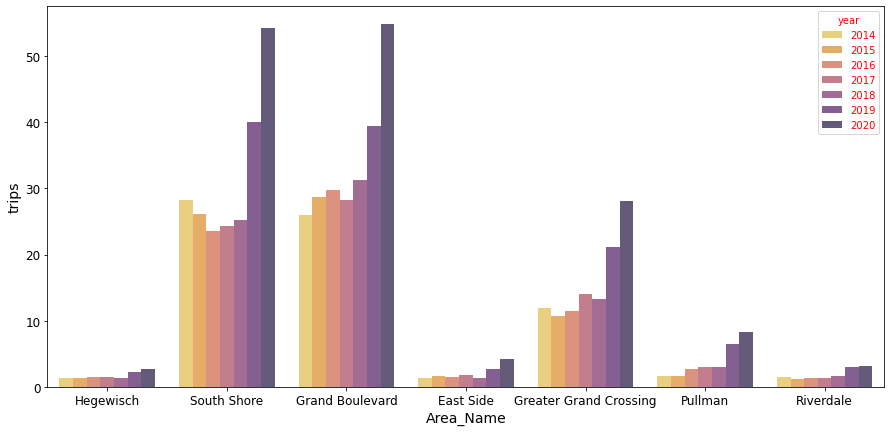

In [55]:
fig = plt.figure(figsize = (15, 7))

sns.barplot(x='Area_Name',y='trips',hue='year',
                palette="inferno_r",
            data=pickup_observations_result,alpha=0.7)

### Below query get the avarage number of trips for the Pullman and Southshore area from Far Southeast side of the city where the density seems slightly increased for dropoff

In [56]:
dropoff_observations = """ SELECT * FROM (SELECT 
                                 EXTRACT(MONTH from trip_start_timestamp) as index,
                                 case when dropoff_community_area = 50 then 'Pullman'
                                      else 'South Shore' end as Area_Name,
                                      CASE WHEN dropoff_community_area in (43,38,69) THEN 'South'
                                      else 'East' END as Region,
                                 EXTRACT(YEAR from trip_start_timestamp) year,
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)) as month,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                 COUNT(*) trips
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                      """ + filters + """
                        AND dropoff_community_area > 0
                        AND dropoff_community_area in (50,43)
                        GROUP BY EXTRACT(MONTH from trip_start_timestamp),
                                  dropoff_community_area,
                                 EXTRACT(YEAR from trip_start_timestamp),
                                 FORMAT_DATETIME("%B", DATETIME(trip_start_timestamp)),
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END ) as a
                        ORDER BY index """

dropoff_observations_job = client.query(dropoff_observations)

dropoff_observations_result = dropoff_observations_job.to_dataframe()


dropoff_observations_east = dropoff_observations_result.loc[dropoff_observations_result['Region'] == 'East']
dropoff_observations_south = dropoff_observations_result.loc[dropoff_observations_result['Region'] == 'South']

### Plotting the avarage number of dropoff for Pullman and South Shore areas

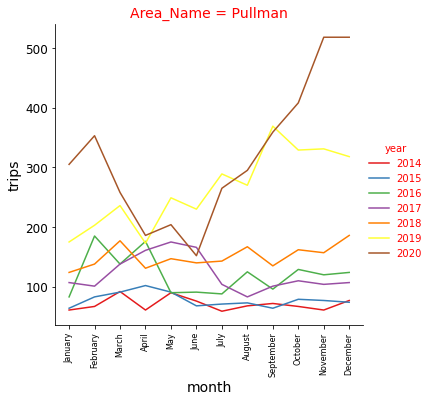

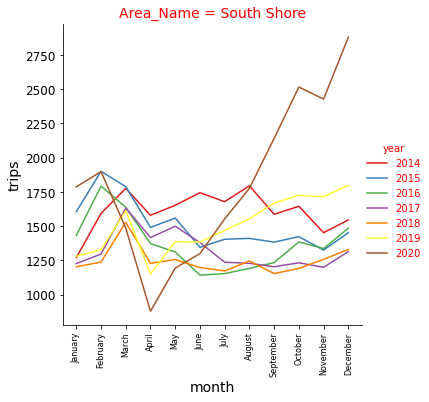

In [57]:
g = sns.relplot(x='month',y='trips',hue='year',col='Area_Name',kind='line',palette="Set1",
            data=dropoff_observations_east)
g.set_xticklabels(rotation=90,size=8)

h = sns.relplot(x='month',y='trips',hue='year',palette="Set1",kind='line',col='Area_Name',
            data=dropoff_observations_south)
h.set_xticklabels(rotation=90,size=8)

1. In earlier sections we have seen densities for community areas.
2. In this section we will see the popular pickup and dropoff locations based on lat long columns
2. The below queries gets the the number of trips for each latitude and longitude combination and then we are filtering top 20 records based on trip count.

In [58]:
# query to get the number of pickups for each latitude and longitude combination
pickup_locations = """ SELECT EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                  pickup_latitude,
                                  pickup_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '07/01/2019') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(YEAR from trip_start_timestamp),
                        CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END,
                        pickup_latitude,pickup_longitude """

pickup_locations_job = client.query(pickup_locations)

pickup_locations_result = pickup_locations_job.to_dataframe()

#Sepearating data for precovid and covid
pickup_before = pickup_locations_result.loc[pickup_locations_result['period'] == 'PRE-COVID']
pickup_after = pickup_locations_result.loc[pickup_locations_result['period'] == 'COVID']

#Sorting the results based on number of trips in descending order
pickup_before=pickup_before.sort_values(by=['trip_count'],ascending=False)
pickup_after=pickup_after.sort_values(by=['trip_count'],ascending=False)

#Filtering TOP 20 records
pickup_before_top20 = pickup_before.head(20)
pickup_after_top20 = pickup_after.head(20)

# query to get the number of dropoffs for each latitude and longitude combination
dropoff_locations = """ SELECT EXTRACT(YEAR from trip_start_timestamp) ride_year,
                                  CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                                  dropoff_latitude,
                                  dropoff_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '07/01/2019') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(YEAR from trip_start_timestamp),
                        CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 4 THEN 'PRE-COVID' ELSE 'COVID' END,
                        dropoff_latitude,dropoff_longitude """

dropoff_locations_job = client.query(dropoff_locations)

dropoff_locations_result = dropoff_locations_job.to_dataframe()

#Sepearating data for precovid and covid
dropoff_before = dropoff_locations_result.loc[dropoff_locations_result['period'] == 'PRE-COVID']
dropoff_after = dropoff_locations_result.loc[dropoff_locations_result['period'] == 'COVID']

#Sorting the results based on number of trips in descending order
dropoff_before=dropoff_before.sort_values(by=['trip_count'],ascending=False)
dropoff_after=dropoff_after.sort_values(by=['trip_count'],ascending=False)

#Filtering TOP 20 records
dropoff_before_top20 = dropoff_before.head(20)
dropoff_after_top20 = dropoff_after.head(20)

### Plotting TOP 20 pickup and dropoff locations on chicago map
1. Green represents pickup locations
2. Red represents dropoff locations

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the con

Text(427.98636363636354, 0.5, 'Latitude')

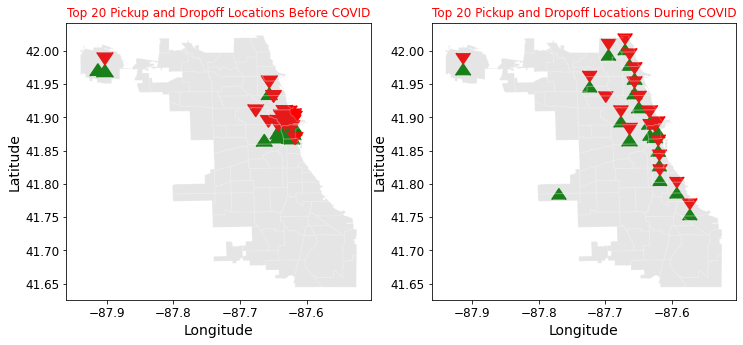

In [59]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

#Setting the size of scatter based on trip count
sizes_pre = np.log10(pickup_before_top20['trip_count'])*50
sizes_post = np.log10(pickup_after_top20['trip_count'])*50

#Plotting top 20 pickup locations before covid
ax1 = pickup_before_top20.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude",
                       title="Top 20 Pickup and Dropoff Locations Before COVID",
                       color="green", s=sizes_pre,
                       ax=ax1, marker = 6
                      )

#Plotting top 20 dropoff locations before covid
ax1 = dropoff_before_top20.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude",
                       title="Top 20 Pickup and Dropoff Locations Before COVID",
                       color="red", s=sizes_pre,
                       ax=ax1, marker = 7
                      )

#Plotting Chicago map
chicago_map.plot(color='grey', edgecolor='white',ax=ax1, alpha = 0.2)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

#Plotting top 20 pickup locations during covid
ax2 = pickup_after_top20.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude",
                       title="Top 20 For Pickup and Dropoff Locations During COVID",
                      color="green", s=sizes_post,
                       ax=ax2, marker = 6
                      )

#Plotting top 20 dropoff locations during covid
ax2 = dropoff_after_top20.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude",
                       title="Top 20 Pickup and Dropoff Locations During COVID",
                       color="red", s=sizes_post,
                       ax=ax2, marker = 7
                      )

#Plotting Chicago map
chicago_map.plot(color='grey', edgecolor='white',ax=ax2, alpha = 0.2)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

### In the below section we are trying to get the locations where the average number of pickups is doubled during the COVID compared to earlier

In [60]:
#Average number of pickups per day before COVID for each location
before_pk = """ SELECT pickup_latitude,
                    pickup_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'PRE-COVID'as period,
                                  pickup_latitude,
                                  pickup_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '01/01/2014') and PARSE_DATE('%m/%d/%Y', '04/30/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        pickup_latitude,pickup_longitude) aa
                GROUP BY pickup_latitude,
                    pickup_longitude"""

#Average number of pickups per day during COVID for each location
after_pk = """ SELECT pickup_latitude,
                    pickup_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'COVID'as period,
                                  pickup_latitude,
                                  pickup_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '05/01/2020') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        pickup_latitude,pickup_longitude) bb 
                GROUP BY pickup_latitude,
                    pickup_longitude"""

#Getting the records where pickups during COVID are more than double the number of pickups before COVID
pickup_inc = """ SELECT a.pickup_latitude,a.pickup_longitude,a.trip_count
                   FROM (""" + after_pk + """) as a
                JOIN (""" + before_pk + """) as b ON a.pickup_latitude = b.pickup_latitude
                   and a.pickup_longitude = b.pickup_longitude
                   and a.trip_count > b.trip_count * 2
                   ORDER BY a.trip_count desc"""

pickup_inc_job = client.query(pickup_inc)

pickup_inc_result = pickup_inc_job.to_dataframe()

#Average number of dropoff per day before COVID for each location
before_df = """ SELECT dropoff_latitude,
                    dropoff_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'PRE-COVID'as period,
                                  dropoff_latitude,
                                  dropoff_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '01/01/2014') and PARSE_DATE('%m/%d/%Y', '04/30/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        dropoff_latitude,dropoff_longitude) aa
                GROUP BY dropoff_latitude,
                    dropoff_longitude"""

#Average number of dropoff per day during COVID for each location
after_df = """ SELECT dropoff_latitude,
                    dropoff_longitude,
                    ROUND(avg(trip_count)) trip_count
                FROM (SELECT EXTRACT(DATE from trip_start_timestamp) date,
                                  'COVID'as period,
                                  dropoff_latitude,
                                  dropoff_longitude,
                                  count(*) trip_count
                           FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
                       """ + filters + """
                           AND extract(DATE from trip_start_timestamp) between PARSE_DATE('%m/%d/%Y', '05/01/2020') and PARSE_DATE('%m/%d/%Y', '12/31/2020')
                        GROUP BY EXTRACT(DATE from trip_start_timestamp),
                        dropoff_latitude,dropoff_longitude) bb 
                GROUP BY dropoff_latitude,
                    dropoff_longitude"""

#Getting the records where dropoff during COVID are more than double the number of dropoffs before COVID
dropoff_inc = """ SELECT a.dropoff_latitude,a.dropoff_longitude,a.trip_count
                   FROM (""" + after_df + """) as a
                JOIN (""" + before_df + """) as b ON a.dropoff_latitude = b.dropoff_latitude
                   and a.dropoff_longitude = b.dropoff_longitude
                   and a.trip_count > b.trip_count * 2
                   ORDER BY a.trip_count desc"""

dropoff_inc_job = client.query(dropoff_inc)

dropoff_inc_result = dropoff_inc_job.to_dataframe()

dropoff_inc_result.head()

dropoff_latitude  dropoff_longitude  trip_count
0         41.706126         -87.598256        11.0
1         41.965363         -87.731833         9.0
2         42.021224         -87.669825         7.0
3         41.990064         -87.723968         7.0
4         41.747732         -87.655937         7.0

### Plotting pickup and dropoff location which are doubled in number of trips using folium
1. Green represents pickup locations
2. Red represents dropoff locations

In [61]:
# Creating intial map to plot the locations setting location to center location with in Chicago city
cmap = folium.Map(location=[41.8781, -87.6298], control_scale=True, zoom_start=12)

# Plotting pickup locations
for row in pickup_inc_result.itertuples():
    p1=[row[1],row[2]]
    folium.CircleMarker(
      location = p1, color='green',
      radius=5,weight=10
     ).add_to(cmap) 
    
# Plotting dropoff locations
for row in dropoff_inc_result.itertuples():
    p1=[row[1],row[2]]
    folium.CircleMarker(
      location = p1, color='red',
      radius=3,weight=10
     ).add_to(cmap) 
    
cmap.save('PickupsDoubledDuringCOVID.html') 

cmap

## Getting full data with the required features for prediction

In [62]:
full_data_query = """ 
            SELECT year,
                   month,
                   hour,
                   weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude,
                   period,
                   trip_count
              FROM (SELECT EXTRACT(YEAR from trip_start_timestamp) as year,
                   EXTRACT(MONTH from trip_start_timestamp) as month,
                   EXTRACT(HOUR from trip_start_timestamp) as hour,
                   EXTRACT(DAYOFWEEK from trip_start_timestamp) as weekday,
                   pickup_community_area,
                   pickup_latitude,
                   pickup_longitude,
                   CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END as period,
                   count(*) as trip_count
            FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
           WHERE extract(YEAR from trip_start_timestamp) BETWEEN 2014 and 2021
             AND pickup_latitude is not null and pickup_longitude is not null
             AND trip_end_timestamp is not null
             AND trip_end_timestamp >= trip_start_timestamp
             AND TIMESTAMP_DIFF(trip_end_timestamp, trip_start_timestamp, MINUTE) < 180
             AND pickup_community_area is not null AND pickup_community_area > 0
             AND dropoff_community_area is not null AND dropoff_community_area > 0
             AND trip_total >= 3.25
             AND trip_miles <= 100
            GROUP BY EXTRACT(YEAR from trip_start_timestamp),
            EXTRACT(MONTH from trip_start_timestamp),
            pickup_community_area,
            pickup_latitude,
            pickup_longitude,
                   EXTRACT(HOUR from trip_start_timestamp),
                   EXTRACT(DAYOFWEEK from trip_start_timestamp),
            CASE WHEN EXTRACT(YEAR from trip_start_timestamp) < 2020 then 'PRE-COVID' WHEN EXTRACT(MONTH from trip_start_timestamp) < 3 THEN 'PRE-COVID' ELSE 'COVID' END)
            ORDER BY year,month        """

full_data_job = client.query(full_data_query)

full_data = full_data_job.to_dataframe()

full_data.head()

year  month  hour  weekday  pickup_community_area  pickup_latitude  \
0  2014      1     1        1                      8        41.899602   
1  2014      1    15        1                      8        41.893216   
2  2014      1    13        6                      8        41.892042   
3  2014      1    20        7                      8        41.899602   
4  2014      1     0        4                     28        41.879067   

   pickup_longitude     period  trip_count  
0        -87.633308  PRE-COVID         511  
1        -87.637844  PRE-COVID         183  
2        -87.631864  PRE-COVID         693  
3        -87.633308  PRE-COVID         362  
4        -87.657005  PRE-COVID          44

## Transferring this data to mongodb

In [63]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [64]:
from pymongo import MongoClient
import pandas as pd
client = MongoClient()

In [65]:
col1 = client['full_data']['my_records']
data1 = full_data.to_dict(orient='records')
col1.insert_many(data1)

## MongoDB -> Jupyter Notebook Using Pyspark

In [66]:
import pymongo
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [67]:
client = pymongo.MongoClient("mongodb://localhost:27017")

In [68]:
db = client['full_data']

In [69]:
print(db)

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'full_data')


In [70]:
mycollection = db['my_records']

In [71]:
one_record = mycollection.find_one()

In [72]:
print(one_record)

{'_id': ObjectId('61b6c105683c2ff0baa2276d'), 'year': 2014, 'month': 1, 'hour': 1, 'weekday': 1, 'pickup_community_area': 8, 'pickup_latitude': 41.899602111, 'pickup_longitude': -87.633308037, 'period': 'PRE-COVID', 'trip_count': 511}


In [73]:
all_records = mycollection.find()

In [74]:
print(all_records)

In [75]:
list_cursor = list(all_records)

In [76]:
df = pd.DataFrame(list_cursor)

In [77]:
df= df.drop('_id',1)

In [78]:
df.head()

year  month  hour  weekday  pickup_community_area  pickup_latitude  \
0  2014      1     1        1                      8        41.899602   
1  2014      1    15        1                      8        41.893216   
2  2014      1    13        6                      8        41.892042   
3  2014      1    20        7                      8        41.899602   
4  2014      1     0        4                     28        41.879067   

   pickup_longitude     period  trip_count  
0        -87.633308  PRE-COVID         511  
1        -87.637844  PRE-COVID         183  
2        -87.631864  PRE-COVID         693  
3        -87.633308  PRE-COVID         362  
4        -87.657005  PRE-COVID          44

In [79]:
data_precovid = df.loc[df['period'] == 'PRE-COVID']

In [80]:
data_precovid.head()

year  month  hour  weekday  pickup_community_area  pickup_latitude  \
0  2014      1     1        1                      8        41.899602   
1  2014      1    15        1                      8        41.893216   
2  2014      1    13        6                      8        41.892042   
3  2014      1    20        7                      8        41.899602   
4  2014      1     0        4                     28        41.879067   

   pickup_longitude     period  trip_count  
0        -87.633308  PRE-COVID         511  
1        -87.637844  PRE-COVID         183  
2        -87.631864  PRE-COVID         693  
3        -87.633308  PRE-COVID         362  
4        -87.657005  PRE-COVID          44

# Importing Pyspark libraries

In [81]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Linear Regression Model").getOrCreate()

In [82]:
sparkDF = spark.createDataFrame(data_precovid)
sparkDF.printSchema()
sparkDF.show()

root
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- hour: long (nullable = true)
 |-- weekday: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- period: string (nullable = true)
 |-- trip_count: long (nullable = true)

+----+-----+----+-------+---------------------+---------------+----------------+---------+----------+
|year|month|hour|weekday|pickup_community_area|pickup_latitude|pickup_longitude|   period|trip_count|
+----+-----+----+-------+---------------------+---------------+----------------+---------+----------+
|2014|    1|   1|      1|                    8|   41.899602111|   -87.633308037|PRE-COVID|       511|
|2014|    1|  15|      1|                    8|    41.89321636|    -87.63784421|PRE-COVID|       183|
|2014|    1|  13|      6|                    8|   41.892042136|    -87.63186395|PRE-COVID|       693|
|2014|    1|  20| 

In [83]:
sparkDF.columns

['year',
 'month',
 'hour',
 'weekday',
 'pickup_community_area',
 'pickup_latitude',
 'pickup_longitude',
 'period',
 'trip_count']

In [84]:
sparkDF = sparkDF.drop('period')

In [85]:
assembler = VectorAssembler(inputCols = ['year','month','hour','weekday','pickup_community_area','pickup_latitude',
                                        ],outputCol='features')
output = assembler.transform(sparkDF)
output.printSchema()

root
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- hour: long (nullable = true)
 |-- weekday: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- trip_count: long (nullable = true)
 |-- features: vector (nullable = true)



In [86]:
output.head()

Row(year=2014, month=1, hour=1, weekday=1, pickup_community_area=8, pickup_latitude=41.899602111, pickup_longitude=-87.633308037, trip_count=511, features=DenseVector([2014.0, 1.0, 1.0, 1.0, 8.0, 41.8996]))

In [87]:
final_data = output.select('features','trip_count')
final_data.show()

+--------------------+----------+
|            features|trip_count|
+--------------------+----------+
|[2014.0,1.0,1.0,1...|       511|
|[2014.0,1.0,15.0,...|       183|
|[2014.0,1.0,13.0,...|       693|
|[2014.0,1.0,20.0,...|       362|
|[2014.0,1.0,0.0,4...|        44|
|[2014.0,1.0,0.0,4...|        54|
|[2014.0,1.0,1.0,2...|       663|
|[2014.0,1.0,0.0,2...|        15|
|[2014.0,1.0,16.0,...|       555|
|[2014.0,1.0,2.0,7...|        45|
|[2014.0,1.0,8.0,3...|        21|
|[2014.0,1.0,21.0,...|        45|
|[2014.0,1.0,21.0,...|       578|
|[2014.0,1.0,13.0,...|       281|
|[2014.0,1.0,19.0,...|      3765|
|[2014.0,1.0,6.0,3...|        98|
|[2014.0,1.0,15.0,...|       409|
|[2014.0,1.0,22.0,...|        83|
|[2014.0,1.0,1.0,7...|        64|
|[2014.0,1.0,21.0,...|      1412|
+--------------------+----------+
only showing top 20 rows



In [88]:
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [89]:
train_data.describe().show()

+-------+------------------+
|summary|        trip_count|
+-------+------------------+
|  count|           1236965|
|   mean|  80.8879337733889|
| stddev|232.99717030296122|
|    min|                 1|
|    max|              6687|
+-------+------------------+



In [90]:
test_data.describe().show()

+-------+------------------+
|summary|        trip_count|
+-------+------------------+
|  count|            530217|
|   mean| 81.23353457169424|
| stddev|232.07334355827695|
|    min|                 1|
|    max|              6668|
+-------+------------------+



# LINEAR REGRESSION MODEL

In [91]:
regressor = LinearRegression(labelCol='trip_count')

In [92]:
model =regressor.fit(train_data)

In [93]:
pred_data =model.evaluate(test_data)
pred_data.residuals.show()

/Users/jaswanthsai/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



+-------------------+
|          residuals|
+-------------------+
| -42.95086175030565|
| -53.11880285445159|
|  36.75859526004024|
|-24.226247789620174|
| -39.27008771055398|
| -50.40344502411972|
|  97.43526829077246|
|-45.981567294957586|
|  96.19626007379156|
| 50.143928079923626|
|  220.9017574775453|
| -3.118234062854299|
|-10.331737663453623|
| -16.38837125660075|
| 23.609131038226224|
|-27.642287995270635|
|  80.80918085699659|
| 46.806362790320236|
|  116.7952104483652|
| 203.77307540426818|
+-------------------+
only showing top 20 rows



In [94]:
print('Root Mean Squared Error:',pred_data.rootMeanSquaredError)

Root Mean Squared Error: 231.25032937461


In [95]:
print('R2 score:',pred_data.r2)

R2 score: 0.007078258303012563


In [96]:
unlabeled_data = test_data.select('features')
test_predictions =model.transform(unlabeled_data)

In [97]:
test_predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[2014.0,1.0,0.0,1...| 54.95086175030565|
|[2014.0,1.0,0.0,1...| 55.11880285445159|
|[2014.0,1.0,0.0,1...| 55.24140473995976|
|[2014.0,1.0,0.0,1...|53.226247789620174|
|[2014.0,1.0,0.0,1...| 53.27008771055398|
|[2014.0,1.0,0.0,1...| 53.40344502411972|
|[2014.0,1.0,0.0,1...|53.564731709227544|
|[2014.0,1.0,0.0,1...|51.981567294957586|
|[2014.0,1.0,0.0,1...|51.803739926208436|
|[2014.0,1.0,0.0,1...|51.856071920076374|
|[2014.0,1.0,0.0,1...| 52.09824252245471|
|[2014.0,1.0,0.0,1...|  52.1182340628543|
|[2014.0,1.0,0.0,1...| 52.33173766345362|
|[2014.0,1.0,0.0,1...| 52.38837125660075|
|[2014.0,1.0,0.0,1...|52.390868961773776|
|[2014.0,1.0,0.0,1...|52.642287995270635|
|[2014.0,1.0,0.0,1...| 51.19081914300341|
|[2014.0,1.0,0.0,1...|51.193637209679764|
|[2014.0,1.0,0.0,1...|  51.2047895516348|
|[2014.0,1.0,0.0,1...|51.226924595731816|
+--------------------+------------